In [1]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
estimators = [('reduce_dim', PCA()), ('clf', SVC())]
pipe = Pipeline(estimators)
pipe

Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC())])

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Binarizer
make_pipeline(Binarizer(), MultinomialNB())

Pipeline(steps=[('binarizer', Binarizer()), ('multinomialnb', MultinomialNB())])

In [4]:
print(pipe.steps[0])

print(pipe[0])

pipe['reduce_dim']

('reduce_dim', PCA())
PCA()


PCA()

In [5]:
pipe.named_steps.reduce_dim is pipe['reduce_dim']

True

In [7]:
print(pipe[:1])

pipe[-1:]

Pipeline(steps=[('reduce_dim', PCA())])


Pipeline(steps=[('clf', SVC())])

In [8]:
pipe.set_params(clf__C=10)


Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC(C=10))])

In [9]:
from sklearn.model_selection import GridSearchCV
param_grid = dict(reduce_dim__n_components=[2, 5, 10],
                  clf__C=[0.1, 10, 100])
grid_search = GridSearchCV(pipe, param_grid=param_grid)

In [10]:
from sklearn.linear_model import LogisticRegression
param_grid = dict(reduce_dim=['passthrough', PCA(5), PCA(10)],
                  clf=[SVC(), LogisticRegression()],
                  clf__C=[0.1, 10, 100])
grid_search = GridSearchCV(pipe, param_grid=param_grid)

In [11]:
pipe[0]

PCA()

In [12]:
pipe['reduce_dim']

PCA()

In [14]:
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print(__doc__)

# import some data to play with
X, y = make_classification(
    n_features=20, n_informative=3, n_redundant=0, n_classes=4,
    n_clusters_per_class=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# ANOVA SVM-C
# 1) anova filter, take 3 best ranked features
anova_filter = SelectKBest(f_classif, k=3)
# 2) svm
clf = svm.LinearSVC()

anova_svm = make_pipeline(anova_filter, clf)
anova_svm.fit(X_train, y_train)
y_pred = anova_svm.predict(X_test)
print(classification_report(y_test, y_pred))

print(anova_svm)

print(anova_svm[:-1])

coef = anova_svm[:-1].inverse_transform(anova_svm['linearsvc'].coef_)
print(coef)

Automatically created module for IPython interactive environment
              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.75      1.00      0.86         6
           2       0.67      0.75      0.71         8
           3       0.75      0.75      0.75         4

    accuracy                           0.76        25
   macro avg       0.79      0.77      0.76        25
weighted avg       0.79      0.76      0.76        25

Pipeline(steps=[('selectkbest', SelectKBest(k=3)), ('linearsvc', LinearSVC())])
Pipeline(steps=[('selectkbest', SelectKBest(k=3))])
[[ 0.          0.          0.          0.          0.         -0.14941637
   0.         -0.01342829 -0.0807033   0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.63074138
   0.          0.02012397 -1.05663198  0.          0.        

In [15]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Mathieu Blondel <mathieu@mblondel.org>
# License: BSD 3 clause
from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# #############################################################################
# Load some categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
]
# Uncomment the following to do the analysis on all the categories
#categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

data = fetch_20newsgroups(subset='train', categories=categories)
print("%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))
print()

# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(data.data, data.target)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Automatically created module for IPython interactive environment
Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc']
857 documents
2 categories

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__max_iter': (20,),
 'clf__penalty': ('l2', 'elasticnet'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   38.5s finished


done in 39.124s

Best score: 0.951
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 20
	clf__penalty: 'elasticnet'
	vect__max_df: 1.0
	vect__ngram_range: (1, 1)


Automatically created module for IPython interactive environment
Best parameter (CV score=0.920):
{'logistic__C': 0.046415888336127774, 'pca__n_components': 45}


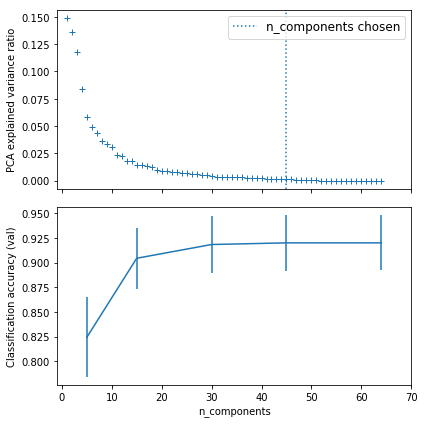

In [17]:
print(__doc__)


# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

X_digits, y_digits = datasets.load_digits(return_X_y=True)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64],
    'logistic__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

Automatically created module for IPython interactive environment


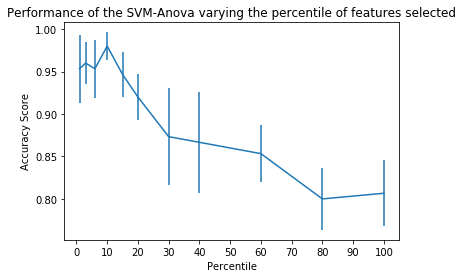

In [18]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


# #############################################################################
# Import some data to play with
X, y = load_iris(return_X_y=True)
# Add non-informative features
np.random.seed(0)
X = np.hstack((X, 2 * np.random.random((X.shape[0], 36))))

# #############################################################################
# Create a feature-selection transform, a scaler and an instance of SVM that we
# combine together to have an full-blown estimator
clf = Pipeline([('anova', SelectPercentile(chi2)),
                ('scaler', StandardScaler()),
                ('svc', SVC(gamma="auto"))])

# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, X, y)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title(
    'Performance of the SVM-Anova varying the percentile of features selected')
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel('Percentile')
plt.ylabel('Accuracy Score')
plt.axis('tight')
plt.show()

Automatically created module for IPython interactive environment
(1797, 64)


C:\Users\efnxqng\AppData\Roaming\Python\Python37\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\efnxqng\AppData\Roaming\Python\Python37\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\efnxqng\AppData\Roaming\Python\Python37\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\efnxqng\AppData\Roaming\Python\Python37\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, 

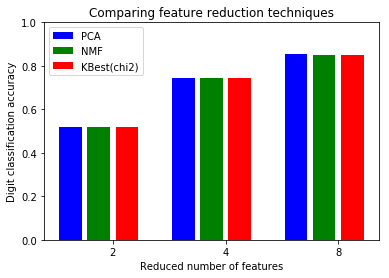

In [20]:
# Authors: Robert McGibbon, Joel Nothman, Guillaume Lemaitre


import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

print(__doc__)

pipe = Pipeline([
    # the reduce_dim stage is populated by the param_grid
    ('reduce_dim', 'passthrough'),
    ('classify', LinearSVC(dual=False, max_iter=10000))
])

N_FEATURES_OPTIONS = [2, 4, 8]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]
reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']

grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid)
X, y = load_digits(return_X_y=True)

print(X.shape)

grid.fit(X, y)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')

plt.show()



In [21]:
from joblib import Memory
from shutil import rmtree

# Create a temporary folder to store the transformers of the pipeline
location = 'cachedir'
memory = Memory(location=location, verbose=10)
cached_pipe = Pipeline([('reduce_dim', PCA()),
                        ('classify', LinearSVC(dual=False, max_iter=10000))],
                       memory=memory)

# This time, a cached pipeline will be used within the grid search


# Delete the temporary cache before exiting
memory.clear(warn=False)
rmtree(location)

In [24]:
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
estimators = [('reduce_dim', PCA()), ('clf', SVC())]
cachedir = mkdtemp()
pipe = Pipeline(estimators, memory=cachedir)
pipe


# Clear the cache directory when you don't need it anymore
rmtree(cachedir)

In [22]:
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)
pca1 = PCA()
svm1 = SVC()
pipe = Pipeline([('reduce_dim', pca1), ('clf', svm1)])
pipe.fit(X_digits, y_digits)

# The pca instance can be inspected directly
print(pca1.components_)


[[-1.77484909e-19 -1.73094651e-02 -2.23428835e-01 ... -8.94184677e-02
  -3.65977111e-02 -1.14684954e-02]
 [ 3.27805401e-18 -1.01064569e-02 -4.90849204e-02 ...  1.76697117e-01
   1.94547053e-02 -6.69693895e-03]
 [-1.68358559e-18  1.83420720e-02  1.26475543e-01 ...  2.32084163e-01
   1.67026563e-01  3.48043832e-02]
 ...
 [ 0.00000000e+00 -6.79747203e-17  1.64431900e-16 ...  1.66533454e-16
   0.00000000e+00 -2.15105711e-16]
 [-0.00000000e+00 -3.63110656e-16  4.09445032e-17 ... -0.00000000e+00
  -5.55111512e-17 -2.28983499e-16]
 [ 1.00000000e+00 -1.68983002e-17  5.73338351e-18 ...  8.66631300e-18
  -1.57615962e-17  4.07058917e-18]]


In [25]:
cachedir = mkdtemp()
pca2 = PCA()
svm2 = SVC()
cached_pipe = Pipeline([('reduce_dim', pca2), ('clf', svm2)],
                       memory=cachedir)
cached_pipe.fit(X_digits, y_digits)


print(cached_pipe.named_steps['reduce_dim'].components_)

# Remove the cache directory
rmtree(cachedir)

[[-1.77484909e-19 -1.73094651e-02 -2.23428835e-01 ... -8.94184677e-02
  -3.65977111e-02 -1.14684954e-02]
 [ 3.27805401e-18 -1.01064569e-02 -4.90849204e-02 ...  1.76697117e-01
   1.94547053e-02 -6.69693895e-03]
 [-1.68358559e-18  1.83420720e-02  1.26475543e-01 ...  2.32084163e-01
   1.67026563e-01  3.48043832e-02]
 ...
 [ 0.00000000e+00 -6.79747203e-17  1.64431900e-16 ...  1.66533454e-16
   0.00000000e+00 -2.15105711e-16]
 [-0.00000000e+00 -3.63110656e-16  4.09445032e-17 ... -0.00000000e+00
  -5.55111512e-17 -2.28983499e-16]
 [ 1.00000000e+00 -1.68983002e-17  5.73338351e-18 ...  8.66631300e-18
  -1.57615962e-17  4.07058917e-18]]


In [26]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X, y = fetch_california_housing(return_X_y=True)
X, y = X[:2000, :], y[:2000]  # select a subset of data
transformer = QuantileTransformer(output_distribution='normal')
regressor = LinearRegression()
regr = TransformedTargetRegressor(regressor=regressor,
                                  transformer=transformer)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
regr.fit(X_train, y_train)

print('R2 score: {0:.2f}'.format(regr.score(X_test, y_test)))

raw_target_regr = LinearRegression().fit(X_train, y_train)
print('R2 score: {0:.2f}'.format(raw_target_regr.score(X_test, y_test)))

2021-01-18 12:57:19,642 INFO Downloading Cal. housing from https://ndownloader.figshare.com/files/5976036 to C:\Users\efnxqng\scikit_learn_data


R2 score: 0.61
R2 score: 0.59


In [27]:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
estimators = [('linear_pca', PCA()), ('kernel_pca', KernelPCA())]
combined = FeatureUnion(estimators)
combined


FeatureUnion(transformer_list=[('linear_pca', PCA()),
                               ('kernel_pca', KernelPCA())])

In [28]:
combined.set_params(kernel_pca='drop')



FeatureUnion(transformer_list=[('linear_pca', PCA()), ('kernel_pca', 'drop')])

In [29]:
# Author: Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 clause

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

iris = load_iris()

X, y = iris.data, iris.target

# This dataset is way too high-dimensional. Better do PCA:
pca = PCA(n_components=2)

# Maybe some original features were good, too?
selection = SelectKBest(k=1)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)
print("Combined space has", X_features.shape[1], "features")

svm = SVC(kernel="linear")

# Do grid search over k, n_components and C:

pipeline = Pipeline([("features", combined_features), ("svm", svm)])

param_grid = dict(features__pca__n_components=[1, 2, 3],
                  features__univ_select__k=[1, 2],
                  svm__C=[0.1, 1, 10])

grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=10)
grid_search.fit(X, y)
print(grid_search.best_estimator_)

Combined space has 3 features
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1 
[CV]  features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1, score=0.933, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1 
[CV]  features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1, score=0.933, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1 
[CV]  features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1, score=0.867, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1 
[CV]  features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1, score=0.933, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1 
[CV]  features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1, score=1.000, total=   0.0s
[CV] feat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s



[CV] features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1 
[CV]  features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1, score=1.000, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=2, svm__C=1 
[CV]  features__pca__n_components=1, features__univ_select__k=2, svm__C=1, score=0.933, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=2, svm__C=1 
[CV]  features__pca__n_components=1, features__univ_select__k=2, svm__C=1, score=0.967, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=2, svm__C=1 
[CV]  features__pca__n_components=1, features__univ_select__k=2, svm__C=1, score=0.933, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=2, svm__C=1 
[CV]  features__pca__n_components=1, features__univ_select__k=2, svm__C=1, score=0.933, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=2, svm__C=1 
[CV]  features__pca__n_components=1, feat

[CV]  features__pca__n_components=3, features__univ_select__k=2, svm__C=1, score=1.000, total=   0.0s
[CV] features__pca__n_components=3, features__univ_select__k=2, svm__C=10 
[CV]  features__pca__n_components=3, features__univ_select__k=2, svm__C=10, score=1.000, total=   0.0s
[CV] features__pca__n_components=3, features__univ_select__k=2, svm__C=10 
[CV]  features__pca__n_components=3, features__univ_select__k=2, svm__C=10, score=1.000, total=   0.0s
[CV] features__pca__n_components=3, features__univ_select__k=2, svm__C=10 
[CV]  features__pca__n_components=3, features__univ_select__k=2, svm__C=10, score=0.900, total=   0.0s
[CV] features__pca__n_components=3, features__univ_select__k=2, svm__C=10 
[CV]  features__pca__n_components=3, features__univ_select__k=2, svm__C=10, score=0.967, total=   0.0s
[CV] features__pca__n_components=3, features__univ_select__k=2, svm__C=10 
[CV]  features__pca__n_components=3, features__univ_select__k=2, svm__C=10, score=1.000, total=   0.0s
Pipeline

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.7s finished


In [30]:
import pandas as pd
X = pd.DataFrame(
    {'city': ['London', 'London', 'Paris', 'Sallisaw'],
     'title': ["His Last Bow", "How Watson Learned the Trick",
               "A Moveable Feast", "The Grapes of Wrath"],
     'expert_rating': [5, 3, 4, 5],
     'user_rating': [4, 5, 4, 3]})

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
column_trans = ColumnTransformer(
    [('city_category', OneHotEncoder(dtype='int'),['city']),
     ('title_bow', CountVectorizer(), 'title')],
    remainder='drop')

column_trans.fit(X)




print(column_trans.get_feature_names())






column_trans.transform(X).toarray()

['city_category__x0_London', 'city_category__x0_Paris', 'city_category__x0_Sallisaw', 'title_bow__bow', 'title_bow__feast', 'title_bow__grapes', 'title_bow__his', 'title_bow__how', 'title_bow__last', 'title_bow__learned', 'title_bow__moveable', 'title_bow__of', 'title_bow__the', 'title_bow__trick', 'title_bow__watson', 'title_bow__wrath']


array([[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]], dtype=int64)

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
ct = ColumnTransformer([
      ('scale', StandardScaler(),
      make_column_selector(dtype_include=np.number)),
      ('onehot',
      OneHotEncoder(),
      make_column_selector(pattern='city', dtype_include=object))])
ct.fit_transform(X)


array([[ 0.90453403,  0.        ,  1.        ,  0.        ,  0.        ],
       [-1.50755672,  1.41421356,  1.        ,  0.        ,  0.        ],
       [-0.30151134,  0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.90453403, -1.41421356,  0.        ,  0.        ,  1.        ]])

In [34]:
column_trans = ColumnTransformer(
    [('city_category', OneHotEncoder(dtype='int'),['city']),
     ('title_bow', CountVectorizer(), 'title')],
    remainder='passthrough')

column_trans.fit_transform(X)


array([[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 5, 4],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 3, 5],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 4],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 5, 3]],
      dtype=int64)

In [35]:
from sklearn.preprocessing import MinMaxScaler
column_trans = ColumnTransformer(
    [('city_category', OneHotEncoder(), ['city']),
     ('title_bow', CountVectorizer(), 'title')],
    remainder=MinMaxScaler())

column_trans.fit_transform(X)[:, -2:]

array([[1. , 0.5],
       [0. , 1. ],
       [0.5, 0.5],
       [1. , 0. ]])

In [36]:
from sklearn.compose import make_column_transformer
column_trans = make_column_transformer(
    (OneHotEncoder(), ['city']),
    (CountVectorizer(), 'title'),
    remainder=MinMaxScaler())
column_trans


ColumnTransformer(remainder=MinMaxScaler(),
                  transformers=[('onehotencoder', OneHotEncoder(), ['city']),
                                ('countvectorizer', CountVectorizer(),
                                 'title')])

In [37]:
from sklearn import set_config
set_config(display='diagram')   
# diplays HTML representation in a jupyter context
column_trans  

ColumnTransformer(remainder=MinMaxScaler(),
                  transformers=[('onehotencoder', OneHotEncoder(), ['city']),
                                ('countvectorizer', CountVectorizer(),
                                 'title')])

In [38]:
from sklearn.utils import estimator_html_repr
with open('my_estimator.html', 'w') as f:  
    f.write(estimator_html_repr(clf))

In [10]:
"""
==================================================
Column Transformer with Heterogeneous Data Sources
==================================================

Datasets can often contain components that require different feature
extraction and processing pipelines. This scenario might occur when:

1. your dataset consists of heterogeneous data types (e.g. raster images and
   text captions),
2. your dataset is stored in a :class:`pandas.DataFrame` and different columns
   require different processing pipelines.

This example demonstrates how to use
:class:`~sklearn.compose.ColumnTransformer` on a dataset containing
different types of features. The choice of features is not particularly
helpful, but serves to illustrate the technique.
"""

# Author: Matt Terry <matt.terry@gmail.com>
#
# License: BSD 3 clause

import numpy as np

from sklearn.preprocessing import FunctionTransformer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC

##############################################################################
# 20 newsgroups dataset
# ---------------------
#
# We will use the :ref:`20 newsgroups dataset <20newsgroups_dataset>`, which
# comprises posts from newsgroups on 20 topics. This dataset is split
# into train and test subsets based on messages posted before and after
# a specific date. We will only use posts from 2 categories to speed up running
# time.

categories = ['sci.med', 'sci.space']
X_train, y_train = fetch_20newsgroups(random_state=1,
                                      subset='train',
                                      categories=categories,
                                      remove=('footers', 'quotes'),
                                      return_X_y=True)
X_test, y_test = fetch_20newsgroups(random_state=1,
                                    subset='test',
                                    categories=categories,
                                    remove=('footers', 'quotes'),
                                    return_X_y=True)

##############################################################################
# Each feature comprises meta information about that post, such as the subject,
# and the body of the news post.

print(X_train[0])

##############################################################################
# Creating transformers
# ---------------------
#
# First, we would like a transformer that extracts the subject and
# body of each post. Since this is a stateless transformation (does not
# require state information from training data), we can define a function that
# performs the data transformation then use
# :class:`~sklearn.preprocessing.FunctionTransformer` to create a scikit-learn
# transformer.


def subject_body_extractor(posts):
    # construct object dtype array with two columns
    # first column = 'subject' and second column = 'body'
    features = np.empty(shape=(len(posts), 2), dtype=object)
    for i, text in enumerate(posts):
        # temporary variable `_` stores '\n\n'
        headers, _, body = text.partition('\n\n')
        # store body text in second column
        features[i, 1] = body

        prefix = 'Subject:'
        sub = ''
        # save text after 'Subject:' in first column
        for line in headers.split('\n'):
            if line.startswith(prefix):
                sub = line[len(prefix):]
                break
        features[i, 0] = sub

    return features


subject_body_transformer = FunctionTransformer(subject_body_extractor)

##############################################################################
# We will also create a transformer that extracts the
# length of the text and the number of sentences.


def text_stats(posts):
    return [{'length': len(text),
             'num_sentences': text.count('.')}
            for text in posts]


text_stats_transformer = FunctionTransformer(text_stats)

##############################################################################
# Classification pipeline
# -----------------------
#
# The pipeline below extracts the subject and body from each post using
# ``SubjectBodyExtractor``, producing a (n_samples, 2) array. This array is
# then used to compute standard bag-of-words features for the subject and body
# as well as text length and number of sentences on the body, using
# ``ColumnTransformer``. We combine them, with weights, then train a
# classifier on the combined set of features.

pipeline = Pipeline([
    # Extract subject & body
    ('subjectbody', subject_body_transformer),
    # Use ColumnTransformer to combine the subject and body features
    ('union', ColumnTransformer(
        [
            # bag-of-words for subject (col 0)
            ('subject', TfidfVectorizer(min_df=50), 0),
            # bag-of-words with decomposition for body (col 1)
            ('body_bow', Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('best', TruncatedSVD(n_components=50)),
            ]), 1),
            # Pipeline for pulling text stats from post's body
            ('body_stats', Pipeline([
                ('stats', text_stats_transformer),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ]), 1),
        ],
        # weight above ColumnTransformer features
        transformer_weights={
            'subject': 0.8,
            'body_bow': 0.5,
            'body_stats': 1.0,
        }
    )),
    # Use a SVC classifier on the combined features
    ('svc', LinearSVC(dual=False)),
], verbose=True)

##############################################################################
# Finally, we fit our pipeline on the training data and use it to predict
# topics for ``X_test``. Performance metrics of our pipeline are then printed.

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print('Classification report:\n\n{}'.format(
    classification_report(y_test, y_pred))
)




transform_pipeline = Pipeline([
    # Extract subject & body
    ('subjectbody', subject_body_transformer),
    # Use ColumnTransformer to combine the subject and body features
    ('union', ColumnTransformer(
        [
            # bag-of-words for subject (col 0)
            ('subject', TfidfVectorizer(min_df=50), 0),
            # bag-of-words with decomposition for body (col 1)
            ('body_bow', Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('best', TruncatedSVD(n_components=50)),
            ]), 1),
            # Pipeline for pulling text stats from post's body
            ('body_stats', Pipeline([
                ('stats', text_stats_transformer),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ]), 1),
        ],
        # weight above ColumnTransformer features
        transformer_weights={
            'subject': 0.8,
            'body_bow': 0.5,
            'body_stats': 1.0,
        }
    ))
], verbose=True)


print(len(X_train))

X_train_trans = transform_pipeline.fit_transform(X_train)

print(X_train_trans.shape)

print(X_train_trans[0])


From: mccall@mksol.dseg.ti.com (fred j mccall 575-3539)
Subject: Re: Metric vs English
Article-I.D.: mksol.1993Apr6.131900.8407
Organization: Texas Instruments Inc
Lines: 31




American, perhaps, but nothing military about it.  I learned (mostly)
slugs when we talked English units in high school physics and while
the teacher was an ex-Navy fighter jock the book certainly wasn't
produced by the military.

[Poundals were just too flinking small and made the math come out
funny; sort of the same reason proponents of SI give for using that.] 

-- 
"Insisting on perfect safety is for people who don't have the balls to live
 in the real world."   -- Mary Shafer, NASA Ames Dryden
[Pipeline] ....... (step 1 of 3) Processing subjectbody, total=   0.0s
[Pipeline] ............. (step 2 of 3) Processing union, total=   0.8s
[Pipeline] ............... (step 3 of 3) Processing svc, total=   0.0s
Classification report:

              precision    recall  f1-score   support

           0       0.84  

In [5]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random

X = sparse_random(100, 100, density=0.01, format='csr',
                  random_state=42)

print(X.shape)
print(X)

svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
svd.fit(X)

transformed_X = svd.transform(X)

print(transformed_X.shape)
print(transformed_X)

print(svd.explained_variance_ratio_)

print(svd.explained_variance_ratio_.sum())

print(svd.singular_values_)

(100, 100)
  (1, 90)	0.09785700271645004
  (2, 52)	0.5353708726383943
  (4, 23)	0.34102017225603387
  (5, 33)	0.6615910659592654
  (6, 30)	0.2363365902687512
  (7, 1)	0.6699699240966567
  (13, 15)	0.5274959445582615
  (15, 13)	0.07198081846332172
  (17, 93)	0.82483715939574
  (19, 48)	0.9276745414995192
  (20, 20)	0.8676416147202234
  (20, 99)	0.07965392762042289
  (21, 3)	0.1261530962878168
  (21, 45)	0.8254583257962852
  (23, 37)	0.9618648743479986
  (23, 53)	0.4418490344777326
  (25, 46)	0.14745260047490116
  (25, 78)	0.19505472223636333
  (27, 29)	0.6685049011509828
  (27, 81)	0.642776550059865
  (28, 83)	0.07173173781490838
  (30, 66)	0.6590346810990013
  (30, 99)	0.9830199980763584
  (31, 17)	0.5998857880527747
  (31, 62)	0.4023935648144301
  :	:
  (73, 39)	0.9925977185816602
  (75, 85)	0.32073309234467307
  (76, 5)	0.48010782795228635
  (76, 28)	0.1514576224004145
  (77, 60)	0.37354029631429553
  (78, 26)	0.12328392745241279
  (78, 81)	0.9726266044325526
  (82, 5)	0.982135184436

In [6]:
"""
===================================
Column Transformer with Mixed Types
===================================

.. currentmodule:: sklearn

This example illustrates how to apply different preprocessing and feature
extraction pipelines to different subsets of features, using
:class:`~compose.ColumnTransformer`. This is particularly handy for the
case of datasets that contain heterogeneous data types, since we may want to
scale the numeric features and one-hot encode the categorical ones.

In this example, the numeric data is standard-scaled after mean-imputation,
while the categorical data is one-hot encoded after imputing missing values
with a new category (``'missing'``).

In addition, we show two different ways to dispatch the columns to the
particular pre-processor: by column names and by column data types.

Finally, the preprocessing pipeline is integrated in a full prediction pipeline
using :class:`~pipeline.Pipeline`, together with a simple classification
model.
"""

# Author: Pedro Morales <part.morales@gmail.com>
#
# License: BSD 3 clause

import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

np.random.seed(0)

# Load data from https://www.openml.org/d/40945
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

print(type(X))
print(X)

# Alternatively X and y can be obtained directly from the frame attribute:
# X = titanic.frame.drop('survived', axis=1)
# y = titanic.frame['survived']

# %%
# Use ``ColumnTransformer`` by selecting column by names
###############################################################################
# We will train our classifier with the following features:
#
# Numeric Features:
#
# * ``age``: float;
# * ``fare``: float.
#
# Categorical Features:
#
# * ``embarked``: categories encoded as strings ``{'C', 'S', 'Q'}``;
# * ``sex``: categories encoded as strings ``{'female', 'male'}``;
# * ``pclass``: ordinal integers ``{1, 2, 3}``.
#
# We create the preprocessing pipelines for both numeric and categorical data.
# Note that ``pclass`` could either be treated as a categorical or numeric
# feature.

numeric_features = ['age', 'fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['embarked', 'sex', 'pclass']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

# %%
# HTML representation of ``Pipeline``
###############################################################################
# When the ``Pipeline`` is printed out in a jupyter notebook an HTML
# representation of the estimator is displayed as follows:
from sklearn import set_config

set_config(display='diagram')
clf

# %%
# Use ``ColumnTransformer`` by selecting column by data types
###############################################################################
# When dealing with a cleaned dataset, the preprocessing can be automatic by
# using the data types of the column to decide whether to treat a column as a
# numerical or categorical feature.
# :func:`sklearn.compose.make_column_selector` gives this possibility.
# First, let's only select a subset of columns to simplify our
# example.

subset_feature = ['embarked', 'sex', 'pclass', 'age', 'fare']
X_train, X_test = X_train[subset_feature], X_test[subset_feature]

# %%
# Then, we introspect the information regarding each column data type.

X_train.info()

# %%
# We can observe that the `embarked` and `sex` columns were tagged as
# `category` columns when loading the data with ``fetch_openml``. Therefore, we
# can use this information to dispatch the categorical columns to the
# ``categorical_transformer`` and the remaining columns to the
# ``numerical_transformer``.

# %%
# .. note:: In practice, you will have to handle yourself the column data type.
#    If you want some columns to be considered as `category`, you will have to
#    convert them into categorical columns. If you are using pandas, you can
#    refer to their documentation regarding `Categorical data
#    <https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html>`_.

from sklearn.compose import make_column_selector as selector

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="category")),
    ('cat', categorical_transformer, selector(dtype_include="category"))
])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])


clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

# %%
# The resulting score is not exactly the same as the one from the previous
# pipeline becase the dtype-based selector treats the ``pclass`` columns as
# a numeric features instead of a categorical feature as previously:

selector(dtype_exclude="category")(X_train)

# %%

selector(dtype_include="category")(X_train)

# %%
# Using the prediction pipeline in a grid search
##############################################################################
# Grid search can also be performed on the different preprocessing steps
# defined in the ``ColumnTransformer`` object, together with the classifier's
# hyperparameters as part of the ``Pipeline``.
# We will search for both the imputer strategy of the numeric preprocessing
# and the regularization parameter of the logistic regression using
# :class:`~sklearn.model_selection.GridSearchCV`.

param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(clf, param_grid, cv=10)
grid_search

# %%
# Calling 'fit' triggers the cross-validated search for the best
# hyper-parameters combination:
#
grid_search.fit(X_train, y_train)

print(f"Best params:")
print(grid_search.best_params_)

# %%
# The internal cross-validation scores obtained by those parameters is:
print(f"Internal CV score: {grid_search.best_score_:.3f}")

# %%
# We can also introspect the top grid search results as a pandas dataframe:
import pandas as pd

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results[["mean_test_score", "std_test_score",
            "param_preprocessor__num__imputer__strategy",
            "param_classifier__C"
            ]].head(5)

# %%
# The best hyper-parameters have be used to re-fit a final model on the full
# training set. We can evaluate that final model on held out test data that was
# not used for hyparameter tuning.
#
print(("best logistic regression from grid search: %.3f"
       % grid_search.score(X_test, y_test)))


<class 'pandas.core.frame.DataFrame'>
      pclass                                               name     sex  \
0        1.0                      Allen, Miss. Elisabeth Walton  female   
1        1.0                     Allison, Master. Hudson Trevor    male   
2        1.0                       Allison, Miss. Helen Loraine  female   
3        1.0               Allison, Mr. Hudson Joshua Creighton    male   
4        1.0    Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   
5        1.0                                Anderson, Mr. Harry    male   
6        1.0                  Andrews, Miss. Kornelia Theodosia  female   
7        1.0                             Andrews, Mr. Thomas Jr    male   
8        1.0      Appleton, Mrs. Edward Dale (Charlotte Lamson)  female   
9        1.0                            Artagaveytia, Mr. Ramon    male   
10       1.0                             Astor, Col. John Jacob    male   
11       1.0  Astor, Mrs. John Jacob (Madeleine Talmadge Force

ValueError: Input contains NaN

In [41]:
import numpy as np
from sklearn.preprocessing import QuantileTransformer
rng = np.random.RandomState(0)
X = np.sort(rng.normal(loc=0.5, scale=0.25, size=(25, 1)), axis=0)
qt = QuantileTransformer(n_quantiles=10, random_state=0)
qt.fit_transform(X)

array([[0.        ],
       [0.09871873],
       [0.10643612],
       [0.11754671],
       [0.21017437],
       [0.21945445],
       [0.23498666],
       [0.32443642],
       [0.33333333],
       [0.41360794],
       [0.42339464],
       [0.46257841],
       [0.47112236],
       [0.49834237],
       [0.59986536],
       [0.63390302],
       [0.66666667],
       [0.68873101],
       [0.69611125],
       [0.81280699],
       [0.82160354],
       [0.88126439],
       [0.90516028],
       [0.99319435],
       [1.        ]])

ValueError: No active dataset house_prices found.

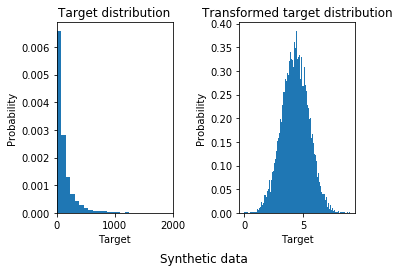

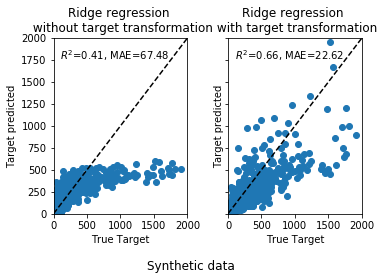

In [42]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
======================================================
Effect of transforming the targets in regression model
======================================================

In this example, we give an overview of
:class:`~sklearn.compose.TransformedTargetRegressor`. We use two examples
to illustrate the benefit of transforming the targets before learning a linear
regression model. The first example uses synthetic data while the second
example is based on the Ames housing data set.
"""

# Author: Guillaume Lemaitre <guillaume.lemaitre@inria.fr>
# License: BSD 3 clause

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.utils.fixes import parse_version

# %%
# Synthetic example
##############################################################################

# `normed` is being deprecated in favor of `density` in histograms
if parse_version(matplotlib.__version__) >= parse_version('2.1'):
    density_param = {'density': True}
else:
    density_param = {'normed': True}

# %%
# A synthetic random regression dataset is generated. The targets ``y`` are
# modified by:
#
#   1. translating all targets such that all entries are
#      non-negative (by adding the absolute value of the lowest ``y``) and
#   2. applying an exponential function to obtain non-linear
#      targets which cannot be fitted using a simple linear model.
#
# Therefore, a logarithmic (`np.log1p`) and an exponential function
# (`np.expm1`) will be used to transform the targets before training a linear
# regression model and using it for prediction.

X, y = make_regression(n_samples=10000, noise=100, random_state=0)
y = np.expm1((y + abs(y.min())) / 200)
y_trans = np.log1p(y)

# %%
# Below we plot the probability density functions of the target
# before and after applying the logarithmic functions.

f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, **density_param)
ax0.set_xlim([0, 2000])
ax0.set_ylabel('Probability')
ax0.set_xlabel('Target')
ax0.set_title('Target distribution')

ax1.hist(y_trans, bins=100, **density_param)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Target')
ax1.set_title('Transformed target distribution')

f.suptitle("Synthetic data", y=0.06, x=0.53)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# %%
# At first, a linear model will be applied on the original targets. Due to the
# non-linearity, the model trained will not be precise during
# prediction. Subsequently, a logarithmic function is used to linearize the
# targets, allowing better prediction even with a similar linear model as
# reported by the median absolute error (MAE).

f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)
# Use linear model
regr = RidgeCV()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
# Plot results
ax0.scatter(y_test, y_pred)
ax0.plot([0, 2000], [0, 2000], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
ax0.text(100, 1750, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)))
ax0.set_xlim([0, 2000])
ax0.set_ylim([0, 2000])
# Transform targets and use same linear model
regr_trans = TransformedTargetRegressor(regressor=RidgeCV(),
                                        func=np.log1p,
                                        inverse_func=np.expm1)
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_test)

ax1.scatter(y_test, y_pred)
ax1.plot([0, 2000], [0, 2000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(100, 1750, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)))
ax1.set_xlim([0, 2000])
ax1.set_ylim([0, 2000])

f.suptitle("Synthetic data", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

# %%
# Real-world data set
###############################################################################
#
# In a similar manner, the Ames housing data set is used to show the impact
# of transforming the targets before learning a model. In this example, the
# target to be predicted is the selling price of each house.

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import QuantileTransformer, quantile_transform

ames = fetch_openml(name="house_prices", as_frame=True)
# Keep only numeric columns
X = ames.data.select_dtypes(np.number)
# Remove columns with NaN or Inf values
X = X.drop(columns=['LotFrontage', 'GarageYrBlt', 'MasVnrArea'])
y = ames.target
y_trans = quantile_transform(y.to_frame(),
                             n_quantiles=900,
                             output_distribution='normal',
                             copy=True).squeeze()
# %%
# A :class:`~sklearn.preprocessing.QuantileTransformer` is used to normalize
# the target distribution before applying a
# :class:`~sklearn.linear_model.RidgeCV` model.

f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, **density_param)
ax0.set_ylabel('Probability')
ax0.set_xlabel('Target')
ax0.text(s='Target distribution', x=1.2e5, y=9.8e-6, fontsize=12)
ax0.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

ax1.hist(y_trans, bins=100, **density_param)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Target')
ax1.text(s='Transformed target distribution', x=-6.8, y=0.479, fontsize=12)

f.suptitle("Ames housing data: selling price", y=0.04)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# %%
# The effect of the transformer is weaker than on the synthetic data. However,
# the transformation results in an increase in :math:`R^2` and large decrease
# of the MAE. The residual plot (predicted target - true target vs predicted
# target) without target transformation takes on a curved, 'reverse smile'
# shape due to residual values that vary depending on the value of predicted
# target. With target transformation, the shape is more linear indicating
# better model fit.

f, (ax0, ax1) = plt.subplots(2, 2, sharey='row', figsize=(6.5, 8))

regr = RidgeCV()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

ax0[0].scatter(y_pred, y_test, s=8)
ax0[0].plot([0, 7e5], [0, 7e5], '--k')
ax0[0].set_ylabel('True target')
ax0[0].set_xlabel('Predicted target')
ax0[0].text(s='Ridge regression \n without target transformation', x=-5e4,
            y=8e5, fontsize=12, multialignment='center')
ax0[0].text(3e4, 64e4, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)))
ax0[0].set_xlim([0, 7e5])
ax0[0].set_ylim([0, 7e5])
ax0[0].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

ax1[0].scatter(y_pred, (y_pred - y_test), s=8)
ax1[0].set_ylabel('Residual')
ax1[0].set_xlabel('Predicted target')
ax1[0].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=900,
                                    output_distribution='normal'))
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_test)

ax0[1].scatter(y_pred, y_test, s=8)
ax0[1].plot([0, 7e5], [0, 7e5], '--k')
ax0[1].set_ylabel('True target')
ax0[1].set_xlabel('Predicted target')
ax0[1].text(s='Ridge regression \n with target transformation', x=-5e4,
            y=8e5, fontsize=12, multialignment='center')
ax0[1].text(3e4, 64e4, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)))
ax0[1].set_xlim([0, 7e5])
ax0[1].set_ylim([0, 7e5])
ax0[1].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

ax1[1].scatter(y_pred, (y_pred - y_test), s=8)
ax1[1].set_ylabel('Residual')
ax1[1].set_xlabel('Predicted target')
ax1[1].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

f.suptitle("Ames housing data: selling price", y=0.035)

plt.show()
